In [15]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import pyfits
from collections import OrderedDict
from astropy.coordinates import SkyCoord
import healpy as hp
from astropy import units as u
from scipy import interpolate, linalg, optimize
from lmfit import Parameters, fit_report, minimize, Minimizer
plt.rcParams['figure.figsize'] = [9, 6]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 0

Deceleration and jerk are fixed to those in Riess et al 2016, while the absolute magnitude is fixed to avoid having to use a local distance ladder, since the objective is only to study the impact of redshift and magnitude discrepancies on H0. Skip to lines 201 for the results.

In [16]:
c = 299792.458 # km/s
Mb = -19.10
q0 = -0.55
j0 = 1


In [17]:
def LoadData():
    #just a file with compiled magnitudes, redshifts etc from JLA, for convenience
    ZTOT = np.load( 'JLADirZInc.npy' )
    #And this one at https://github.com/cmbant/CosmoMC/blob/master/data/jla_lcparams.txt
    #Or download from http://supernovae.in2p3.fr/sdss_snls_jla/ReadMe.html
    jlarr = np.genfromtxt('jla_lcparams.txt', skip_header=1)
    ZHEL = jlarr.transpose()[2]
    ZCMB = jlarr.transpose()[1]
    #Find this file at : https://github.com/dscolnic/Pantheon/blob/master/lcparam_full_long_zhel.txt
    panarr = np.genfromtxt('lcparam_full_long_zhel.txt', skip_header=1)
    pannames = np.asarray([k.split()[0] for k in open('lcparam_full_long_zhel.txt').readlines()[1:]])
    #And this one at https://github.com/cmbant/CosmoMC/blob/master/data/jla_lcparams.txt
    #Or download from http://supernovae.in2p3.fr/sdss_snls_jla/ReadMe.html
    jlarr = np.genfromtxt('jla_lcparams.txt', skip_header=1)
    jlnames = np.asarray([k.split()[0] for k in open('jla_lcparams.txt').readlines()[1:]])
    plines = open('lcparam_full_long_zhel.txt').readlines()[1:]
    jlnamesn = np.asarray([k.replace('sn', '').replace('SDSS','') for k in jlnames])
    #Get this from  https://zenodo.org/record/34487, or use an identity matrix. You may also use the full stat+syst covariance matrix. Makes hardly any difference
    COVT = np.load( 'stat.npy' )    
    zhdiffs=OrderedDict()
    panzs = OrderedDict()
    panzcs = OrderedDict()
    panmbs = OrderedDict()
    panx1s = OrderedDict()
    pancolors = OrderedDict()
    jlzs = OrderedDict()
    jlras = OrderedDict()
    jldecs = OrderedDict()
    injla =[]
    for i in range(len(jlnamesn)):
    #print jlnamesn[i], pannames[pannames==jlnamesn[i]]
        if jlnamesn[i] in pannames:
            injla.append(True)
            #print jlarr.transpose()[2][i], panarr.transpose()[2][pannames==jlnamesn[i]]
            zhdiffs[jlnamesn[i]] = jlarr.transpose()[2][i] - panarr.transpose()[2][pannames==jlnamesn[i]][0]#the difference between pantheon and jla redshifts (zhel)
            panzs[jlnamesn[i]] = panarr.transpose()[2][pannames==jlnamesn[i]][0]#pantheon zhel
            panzcs[jlnamesn[i]] = panarr.transpose()[1][pannames==jlnamesn[i]][0]#pantheon zcmb
            panmbs[jlnamesn[i]] = panarr.transpose()[4][pannames==jlnamesn[i]][0]
            panx1s[jlnamesn[i]] = panarr.transpose()[6][pannames==jlnamesn[i]][0]
            pancolors[jlnamesn[i]] = panarr.transpose()[8][pannames==jlnamesn[i]][0]
            jlras[jlnamesn[i]] = jlarr.transpose()[18][i]
            jldecs[jlnamesn[i]] = jlarr.transpose()[19][i]
            jlzs[jlnamesn[i]] = jlarr.transpose()[2][i]#jla redshifts
        else:
            injla.append(False)
    
    jnzd = np.asarray(list(zhdiffs.values()))
    return jnzd

In [18]:
def GenerateDsetAndCov(shiftsel, verbose=False):
    ZTOT = np.load( 'JLADirZInc.npy' )
    jlarr = np.genfromtxt('jla_lcparams.txt', skip_header=1)
    ZHEL = jlarr.transpose()[2]
    ZCMB = jlarr.transpose()[1]
    #Find this file at : https://github.com/dscolnic/Pantheon/blob/master/lcparam_full_long_zhel.txt
    panarr = np.genfromtxt('lcparam_full_long_zhel.txt', skip_header=1)
    pannames = np.asarray([k.split()[0] for k in open('lcparam_full_long_zhel.txt').readlines()[1:]])
    #And this one at https://github.com/cmbant/CosmoMC/blob/master/data/jla_lcparams.txt
    #Or download from http://supernovae.in2p3.fr/sdss_snls_jla/ReadMe.html
    jlarr = np.genfromtxt('jla_lcparams.txt', skip_header=1)
    jlnames = np.asarray([k.split()[0] for k in open('jla_likelihood_v6/data/jla_lcparams.txt').readlines()[1:]])
    plines = open('lcparam_full_long_zhel.txt').readlines()[1:]
    jlnamesn = np.asarray([k.replace('sn', '').replace('SDSS','') for k in jlnames])
    COVT = np.load( 'stat.npy' )    
    zhdiffs=OrderedDict()
    panzs = OrderedDict()
    panzcs = OrderedDict()
    panmbs = OrderedDict()
    panx1s = OrderedDict()
    pancolors = OrderedDict()
    jlzs = OrderedDict()
    jlras = OrderedDict()
    jldecs = OrderedDict()
    injla =[]
    for i in range(len(jlnamesn)):
    #print jlnamesn[i], pannames[pannames==jlnamesn[i]]
        if jlnamesn[i] in pannames:
            injla.append(True)
            #print jlarr.transpose()[2][i], panarr.transpose()[2][pannames==jlnamesn[i]]
            zhdiffs[jlnamesn[i]] = jlarr.transpose()[2][i] - panarr.transpose()[2][pannames==jlnamesn[i]][0]#the difference between pantheon and jla redshifts (zhel)
            panzs[jlnamesn[i]] = panarr.transpose()[2][pannames==jlnamesn[i]][0]#pantheon zhel
            panzcs[jlnamesn[i]] = panarr.transpose()[1][pannames==jlnamesn[i]][0]#pantheon zcmb
            panmbs[jlnamesn[i]] = panarr.transpose()[4][pannames==jlnamesn[i]][0]
            panx1s[jlnamesn[i]] = panarr.transpose()[6][pannames==jlnamesn[i]][0]
            pancolors[jlnamesn[i]] = panarr.transpose()[8][pannames==jlnamesn[i]][0]
            jlras[jlnamesn[i]] = jlarr.transpose()[18][i]
            jldecs[jlnamesn[i]] = jlarr.transpose()[19][i]
            jlzs[jlnamesn[i]] = jlarr.transpose()[2][i]#jla redshifts
        else:
            injla.append(False)
    
    jnn = np.asarray(zhdiffs.keys())
    jnzd = np.asarray(list(zhdiffs.values()))
    jlzarr = np.asarray(list(jlzs.values()))
    panzarr = np.asarray(list(panzs.values()))
    panzcarr = np.asarray(list(panzcs.values()))
    panmbarr = np.asarray(list(panmbs.values()))
    panx1arr = np.asarray(list(panx1s.values()))
    pancolorarr = np.asarray(list(pancolors.values()))
    jlraarr = np.asarray(jlras.values())
    jldecarr = np.asarray(jldecs.values())
    
    #global ZTOT, COVT
    Z = ZTOT[injla][shiftsel]
    if verbose:
        print(np.shape(Z))
        print(np.shape(panzarr[shiftsel]))
    newpzs = np.reshape(panzarr[shiftsel], newshape=(len(Z),1))
    newpmbs = np.reshape(panmbarr[shiftsel], newshape=(len(Z),1))
    newpmx1s = np.reshape(panx1arr[shiftsel], newshape=(len(Z),1))
    newpmcolors = np.reshape(pancolorarr[shiftsel], newshape=(len(Z),1))
    newpzcs = np.reshape(panzcarr[shiftsel], newshape=(len(Z),1))

    Z = np.append(Z, newpzs, axis=1)
    Z = np.append(Z, newpmbs, axis=1)
    Z = np.append(Z, newpmx1s, axis=1)
    Z = np.append(Z, newpmcolors, axis=1)
    Z = np.append(Z, newpzcs, axis=1)
    cinjla = np.repeat(injla, 3)
    cshiftsel = np.repeat(shiftsel, 3)
    COVd = COVT.transpose()[cinjla].transpose()[cinjla]
    COVd = COVd.transpose()[cshiftsel].transpose()[cshiftsel]
    
    return Z, COVd

In [19]:
def MUZ(Zc, Q0, J0, h=0.7):
    H0 = 100.*h
    k = 5.*np.log10( c/H0 * dLPhenoF3(Zc, Q0, J0)) + 25.   
    if np.any(np.isnan(k)) or np.any(np.isinf(k)):
        #print 'Fuck', Q0, J0, OK
        #print np.min(Zc[np.isnan(k)]), np.max(Zc[np.isnan(k)]), len(Zc[np.isnan(k)])
        k[np.isnan(k)] = 63000.15861331456834
        k[np.isinf(k)] = 630000.15661331456834
        #print 'This is k', k
    return k

def dLPhenoF3(z, q0, j0):
    return z*(1.+0.5*(1.-q0)*z -1./6.*(1. - q0 - 3.*q0**2. + j0)*z**2.)


In [20]:
def m2loglike(pars , RV = 0):
    if RV != 0 and RV != 1 and RV != 2:
        raise ValueError('Inappropriate RV value')
    else:
        cov = COV( *[ pars[i] for i in [2,5,9,4,7] ] )
        try:
            chol_fac = linalg.cho_factor(cov, overwrite_a = True, lower = True ) 
        except np.linalg.linalg.LinAlgError: # If not positive definite
            return +13993*10.**20 
        except ValueError: # If contains infinity
            return 13995*10.**20
        
        res = RESVF3( *[ pars[i] for i in [0,1, 2 ,5,8,3,6, 10] ] )
        part_log = 3*N*np.log(2*np.pi) + np.sum( np.log( np.diag( chol_fac[0] ) ) ) * 2
        part_exp = np.dot( res, linalg.cho_solve( chol_fac, res) )

        if pars[0]<-4 or pars[0]>4. or pars[1]<-4. or pars[1]>4. or pars[4]<0 or pars[7]<0 or pars[9]<0:
            part_exp += 100* np.sum(np.array([ _**2 for _ in pars ]))
            # if outside valid region, give penalty

        if RV==0:
            m2loglike = part_log + part_exp
            return m2loglike 
        elif RV==1: 
            return part_exp 
        elif RV==2:
            return part_log

In [21]:
def RESVF3( Q0, J0 , A , B , M0, X0, C0, h ): #Total residual, \hat Z - Y_0*A
    global ZINDEX
    Y0A = np.array([ M0-A*X0+B*C0, X0, C0 ])
    mu = MUZ(Z[:,ZINDEX], Q0, J0, h) ;
    return np.hstack( [ (Z[i,1:4] -np.array([mu[i],0,0]) - Y0A ) for i in range(N) ] )  

def RESVF3CC( Q0, J0 , A , B , M0, h ): #Total residual, \hat Z - Y_0*A
    global ZINDEX
    global MAGINDEX
    global COLORINDEX
    global STRETCHINDEX
    N=len(Z)
    mu = MUZ(Z[:,ZINDEX], Q0, J0, h) ;
    return Z[:,MAGINDEX] - M0 + A * Z[:,STRETCHINDEX] - B * Z[:,COLORINDEX] - mu

The parameters are $q_0, j_0,  \alpha,  x_{1,0}, \sigma_{x1, 0}, \beta , c_0, \sigma_{c_0}, M_0, \sigma_{M_0}, h$ 


In [22]:
fguesspars = np.array([ -2.83972523e-01,   3.72853954e-02, 1.34264132e-01,
        3.80475068e-02,   8.68197018e-01,   3.05785939e+00,
        -1.60647397e-02,   5.04579592e-03,  -1.90471017e+01,
        1.17220172e-02, 0.7])

In [23]:
bnds = ((-4.,4.),(-4.,4.),
            (None,None),(None,None),(0,None),
            (None,None),(None,None),(0,None),
            (None,None),(0,None), (0, 1.5) )

In [24]:
def COV( A , B , VM, VX, VC , RV=0): # Total covariance matrix
    block3 = np.array( [[VM + VX*A**2 + VC*B**2,    -VX*A, VC*B],
                                                [-VX*A , VX, 0],
                                                [ VC*B ,  0, VC]] )
    ATCOVlA = linalg.block_diag( *[ block3 for i in range(N) ] ) ;
    
    if RV==0:
        return np.array( COVd + ATCOVlA );
    elif RV==1:
        return np.array( COVd );
    elif RV==2:
        return np.array( ATCOVlA );

In [25]:
def m2CONSDec(pars):
    return pars[0] + 0.55

def m2CONSJerk(pars):
    return pars[1] - 1

def m2CONSMag(pars):
    global Mb
    return pars[8] - Mb



In [26]:
ZINDEX = 0
#jlzhres = optimize.minimize(m2loglike, fguesspars, method = 'SLSQP', tol=10**-12,  options={'maxiter': 24000}, constraints = ({'type':'eq', 'fun':m2CONSDec}, {'type':'eq', 'fun':m2CONSJerk}, {'type':'eq', 'fun':m2CONSMag}, {'type':'eq', 'fun':m2BetaFixer}, {'type':'eq', 'fun':m2AlphaFixer}, {'type':'eq', 'fun':m2X10Fixer},  {'type':'eq', 'fun':m2Cfixer}), bounds=bnds)
#print(jlzhres)

The parameters are $q_0, j_0,  \alpha,  x_{1,0}, \sigma_{x1, 0}, \beta , c_0, \sigma_{c_0}, M_0, \sigma_{M_0}, h$ 


Different types of likelihoods, such as the typical 'constrained chi square' method or the likelihoods used in Nielsen et al 2015. Since the primary shifts originate from the mysteriously changing redshifts, verifying that the relative shifts are independent of the likelihood used is left as an exercise to the reader. 

In [27]:
def m2loglike(pars , RV = 0):
    if RV != 0 and RV != 1 and RV != 2:
        raise ValueError('Inappropriate RV value')
    else:
        cov = COV( *[ pars[i] for i in [2,5,9,4,7] ] )
        try:
            chol_fac = linalg.cho_factor(cov, overwrite_a = True, lower = True ) 
        except np.linalg.linalg.LinAlgError: # If not positive definite
            return +13993*10.**20 
        except ValueError: # If contains infinity
            return 13995*10.**20
        
        res = RESVF3( *[ pars[i] for i in [0,1, 2 ,5,8,3,6, 10] ] )
        part_log = 3*N*np.log(2*np.pi) + np.sum( np.log( np.diag( chol_fac[0] ) ) ) * 2
        part_exp = np.dot( res, linalg.cho_solve( chol_fac, res) )

        if pars[0]<-4 or pars[0]>4. or pars[1]<-4. or pars[1]>4. or pars[4]<0 or pars[7]<0 or pars[9]<0:
            part_exp += 100* np.sum(np.array([ _**2 for _ in pars ]))
            # if outside valid region, give penalty

        if RV==0:
            m2loglike = part_log + part_exp
            return m2loglike 
        elif RV==1: 
            return part_exp 
        elif RV==2:
            return part_log


def COV_C( A , B , VM ):
    N=len(Z)
    block1 = np.array( [1 , A , -B] ) ;
    AJLA = linalg.block_diag( *[ block1 for i in range(N) ] );
    return np.dot( AJLA, np.dot( COVd, AJLA.transpose() ) ) + np.eye(N) * VM;

# pars = [ qm, J, a, b, m0, h] , VM seperate

def chi2_C( pars, VM=0.13**2 ):
    cov = COV_C( pars[2], pars[3] , VM )
    chol_fac = linalg.cho_factor( cov, overwrite_a = True, lower = True )
    
    res = RESVF3CC( *pars )
    
    part_exp = np.dot( res , linalg.cho_solve( chol_fac, res) )
    return part_exp

def chi2_CVM( pars):
    cov = COV_C( pars[2], pars[3] , pars[6] )
    chol_fac = linalg.cho_factor( cov, overwrite_a = True, lower = True )
    N=len(Z)
    
    res = RESVF3CC( *[ pars[i] for i in [0,1, 2 ,3,4,5 ] ]  )
    
    part_log = 3*N*np.log(2*np.pi) + np.sum( np.log( np.diag( chol_fac[0] ) ) ) * 2
    
    part_exp = np.dot( res , linalg.cho_solve( chol_fac, res) )
    return part_exp + part_log

def lmfitccVM(lmpars):
    sppars = list(lmpars.valuesdict().values())
    v = chi2_CVM(sppars)
    if np.isnan(v):
        return -13993*10.**20
    return -1.*v


In [28]:
bndsCC = ((-4.,4.),(-4.,4.), (None,None),(None,None), (None,None), (0, 1.5))
bndsCCVM = ((-4.,4.),(-4.,4.), (None,None),(None,None), (None,None), (0, 1.5), (0, None))

In [29]:
def chi2CONSMag(pars):
    global Mb
    return pars[4] - Mb

The parameters are $q_0, j_0,  \alpha,  \beta ,  M_0, h ,\sigma_{int}$ 

In [30]:
fguessparsCCVM = np.array([ -0.55,   1, 1.53257992e-01,
        3.40217404e+00,   -1.90471017e+01,   0.7, 0.13])

In [31]:
ZINDEX = 9
MAGINDEX = 1
STRETCHINDEX = 2
COLORINDEX = 3
#jlzresCC = optimize.minimize(chi2_C, fguessparsCC, method = 'SLSQP', tol=10**-12,  options={'maxiter': 24000}, constraints = (  {'type':'eq', 'fun':chi2CONSMag} , {'type':'eq', 'fun':m2CONSJerk} ), bounds=bndsCC)
#print(jlzresCC)

In [32]:
#ZINDEX = 10
#panzresCC = optimize.minimize(chi2_C, fguessparsCC, method = 'SLSQP', tol=10**-12,  options={'maxiter': 24000}, constraints = ({'type':'eq', 'fun':chi2CONSMag}  , {'type':'eq', 'fun':m2CONSJerk} ), bounds=bndsCC)
#print(panzresCC)

In [34]:
ZINDEX = 9
MAGINDEX = 1
STRETCHINDEX = 2
COLORINDEX = 3
jlzresCCVM = optimize.minimize(chi2_CVM, fguessparsCCVM, method = 'SLSQP', tol=10**-14,  options={'maxiter': 24000}, constraints = ({'type':'eq', 'fun':m2CONSDec},  {'type':'eq', 'fun':m2CONSJerk}, {'type':'eq', 'fun':chi2CONSMag}), bounds=bndsCCVM)
print(jlzresCCVM)

/groups/icecube/mrameez/python35/python/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


     fun: 115.37401261309245
     jac: array([-1.39668865e+01, -1.10360527e+00,  3.81469727e-06, -8.58306885e-06,
        1.04904175e-04,  1.48773193e-04, -2.76565552e-05])
 message: 'Optimization terminated successfully.'
    nfev: 475
     nit: 46
    njev: 46
  status: 0
 success: True
       x: array([-5.50000000e-01,  1.00000000e+00,  1.42202119e-01,  2.61239634e+00,
       -1.91000000e+01,  6.86140252e-01,  1.16705380e-02])


In [35]:
len(Z[:,ZINDEX])

45

In [38]:
Z[:,13]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [39]:
Z[:,1]

array([21.099, 20.351, 19.579, 22.3  , 20.85 , 20.856, 19.838, 21.35 ,
       21.246, 22.21 , 19.709, 20.505, 21.86 , 21.587, 20.359, 22.06 ,
       21.006, 20.556, 20.89 , 20.775, 21.533, 20.257, 19.97 , 19.773,
       20.404, 22.136, 20.557, 21.303, 21.478, 21.278, 20.091, 22.008,
       22.096, 20.425, 21.207, 21.439, 21.832, 21.508, 19.196, 21.379,
       21.246, 20.907, 20.554, 21.111, 16.85 ])

In [40]:
jnzd = LoadData()
shiftsel = jnzd< -0.0025
Z, COVd = GenerateDsetAndCov(shiftsel)
print(len(Z))

45


In [13]:
jnzd = LoadData()
shiftsel = jnzd>0.0025
Z, COVd = GenerateDsetAndCov(shiftsel)
print(len(Z))

13


In [42]:
lmp = Parameters()
pnames = ['Q0', 'J0', 'alpha', 'beta', 'M0', 'h' ,'sigint']
fguessparsCCVM = np.array([ -0.55,   1, 1.53257992e-01, 3.40217404e+00,   -1.91e+01,   0.7, 0.13])
tovary = [False, False, True, True, False, True, True]
bndsCCVM = ((-4.,4.),(-4.,4.), (None,None),(None,None), (None,None), (0, 1.5), (0, None))
inguess = fguessparsCCVM
for val, name, bnd, wtv in zip(inguess, pnames, bndsCCVM, tovary):
    lmp.add(name, value=val, min=bnd[0], max=bnd[1], vary=wtv)

In [43]:
ZINDEX = 9
MAGINDEX = 1
STRETCHINDEX = 2
COLORINDEX = 3
jlzresCCVM = optimize.minimize(chi2_CVM, fguessparsCCVM, method = 'SLSQP', tol=10**-14,  options={'maxiter': 24000}, constraints = ({'type':'eq', 'fun':m2CONSDec},  {'type':'eq', 'fun':m2CONSJerk}, {'type':'eq', 'fun':chi2CONSMag}), bounds=bndsCCVM)
print(jlzresCCVM)

     fun: 115.37401261309275
     jac: array([-1.39669161e+01, -1.10357761e+00, -1.04904175e-05,  2.38418579e-05,
        1.26838684e-04,  3.05175781e-05,  5.72204590e-06])
 message: 'Optimization terminated successfully.'
    nfev: 315
     nit: 32
    njev: 31
  status: 0
 success: True
       x: array([-5.50000000e-01,  1.00000000e+00,  1.42202118e-01,  2.61239614e+00,
       -1.91000000e+01,  6.86140252e-01,  1.16705390e-02])


In [44]:
minner = Minimizer(lmfitccVM, lmp)
resultz9m1sp0025 = minner.emcee(steps = 1500, nwalkers=100, burn=1000)

In [45]:
ZINDEX = 10
MAGINDEX = 1
STRETCHINDEX = 2
COLORINDEX = 3
jlzresCCVM10m1sp0025 = optimize.minimize(chi2_CVM, fguessparsCCVM, method = 'SLSQP', tol=10**-14,  options={'maxiter': 24000}, constraints = ({'type':'eq', 'fun':m2CONSDec},  {'type':'eq', 'fun':m2CONSJerk}, {'type':'eq', 'fun':chi2CONSMag}), bounds=bndsCCVM)
print(jlzresCCVM10m1sp0025)

/groups/icecube/mrameez/python35/python/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


     fun: 110.6490817484835
     jac: array([-7.79404736e+00, -5.06704330e-01, -1.14440918e-05,  7.62939453e-06,
        1.48773193e-04,  2.86102295e-05,  2.02178955e-04])
 message: 'Optimization terminated successfully.'
    nfev: 305
     nit: 30
    njev: 29
  status: 0
 success: True
       x: array([-5.50000000e-01,  1.00000000e+00,  1.40218041e-01,  2.50142845e+00,
       -1.91000000e+01,  7.14187554e-01,  9.80169951e-03])


In [46]:
minner = Minimizer(lmfitccVM, lmp)
resultz10m1sp0025 = minner.emcee(steps = 1500, nwalkers=100, burn=1000)

In [47]:
ZINDEX = 10
MAGINDEX = 11
STRETCHINDEX = 12
COLORINDEX = 13
jlzresCCVM10m11sp0025 = optimize.minimize(chi2_CVM, fguessparsCCVM, method = 'SLSQP', tol=10**-14,  options={'maxiter': 24000}, constraints = ({'type':'eq', 'fun':m2CONSDec},  {'type':'eq', 'fun':m2CONSJerk}, {'type':'eq', 'fun':chi2CONSMag}), bounds=bndsCCVM)
print(jlzresCCVM10m11sp0025)

     fun: 103.94690750985563
     jac: array([8.78104305e+00, 1.48505974e+00, 3.81469727e-06, 7.62939453e-06,
       1.52587891e-04, 9.53674316e-05, 4.38690186e-05])
 message: 'Optimization terminated successfully.'
    nfev: 367
     nit: 35
    njev: 35
  status: 0
 success: True
       x: array([-5.50000000e-01,  1.00000000e+00,  8.67063625e-02, -4.97013901e-01,
       -1.91000000e+01,  7.93032183e-01,  7.88625564e-03])


In [48]:
minner = Minimizer(lmfitccVM, lmp)
resultz10m11sp0025 = minner.emcee(steps = 1500, nwalkers=100, burn=1000)

In [49]:
np.linspace(101, 55., 85.)

/groups/icecube/mrameez/python35/python/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


array([101.        , 100.45238095,  99.9047619 ,  99.35714286,
        98.80952381,  98.26190476,  97.71428571,  97.16666667,
        96.61904762,  96.07142857,  95.52380952,  94.97619048,
        94.42857143,  93.88095238,  93.33333333,  92.78571429,
        92.23809524,  91.69047619,  91.14285714,  90.5952381 ,
        90.04761905,  89.5       ,  88.95238095,  88.4047619 ,
        87.85714286,  87.30952381,  86.76190476,  86.21428571,
        85.66666667,  85.11904762,  84.57142857,  84.02380952,
        83.47619048,  82.92857143,  82.38095238,  81.83333333,
        81.28571429,  80.73809524,  80.19047619,  79.64285714,
        79.0952381 ,  78.54761905,  78.        ,  77.45238095,
        76.9047619 ,  76.35714286,  75.80952381,  75.26190476,
        74.71428571,  74.16666667,  73.61904762,  73.07142857,
        72.52380952,  71.97619048,  71.42857143,  70.88095238,
        70.33333333,  69.78571429,  69.23809524,  68.69047619,
        68.14285714,  67.5952381 ,  67.04761905,  66.5 

(1, 40000)

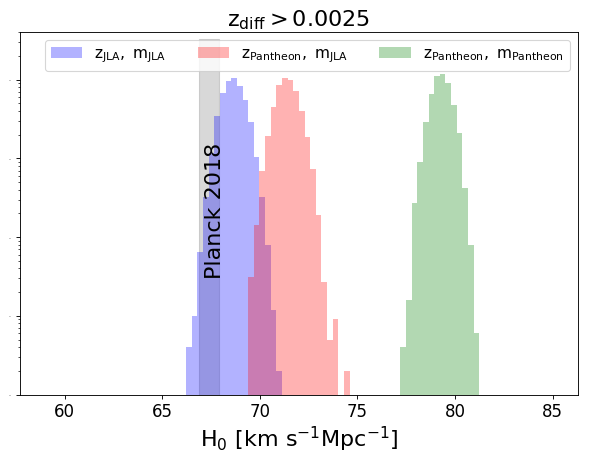

In [124]:
k = plt.hist(resultz9m1sp0025.flatchain['h']*100., bins=np.linspace(59., 85., 91), color='blue', alpha=0.3, label = r'$\rm{ z_{JLA},\  m_{JLA} }$')
plt.hist(resultz10m1sp0025.flatchain['h']*100., bins=k[1], color='red', alpha=0.3, label = r'$\rm{ z_{Pantheon},\  m_{JLA} }$')
plt.hist(resultz10m11sp0025.flatchain['h']*100., bins=k[1], color='green', alpha=0.3, label = r'$\rm{ z_{Pantheon},\ m_{Pantheon} }$')
plt.fill_betweenx(y, x1, x2, color='grey', alpha=0.3)
plt.text(67.2, 1000, 'Planck 2018', rotation=90, fontsize=20)
plt.xlabel(r'$ {\rm H_0 }\ [{\rm km\ s}^{-1} {\rm Mpc}^{-1}]$', fontsize=20)
plt.legend(loc='best', fontsize=14, ncol=3)
plt.title(r'$\rm{ z_{diff} > 0.0025 }$', fontsize=20)
plt.yscale('log')
plt.ylim(1, 40000)


In [77]:
shiftsel = jnzd<-0.0005
Z, COVd = GenerateDsetAndCov(shiftsel)
print(len(Z))

78


In [78]:
ZINDEX = 9
MAGINDEX = 1
STRETCHINDEX = 2
COLORINDEX = 3
jlzresCCVM = optimize.minimize(chi2_CVM, fguessparsCCVM, method = 'SLSQP', tol=10**-14,  options={'maxiter': 24000}, constraints = ({'type':'eq', 'fun':m2CONSDec},  {'type':'eq', 'fun':m2CONSJerk}, {'type':'eq', 'fun':chi2CONSMag}), bounds=bndsCCVM)
print(jlzresCCVM)

     fun: 207.30172777564198
     jac: array([8.92670708e+01, 2.27181129e+01, 5.72204590e-05, 2.47955322e-05,
       1.81198120e-04, 1.73568726e-04, 6.67572021e-05])
 message: 'Optimization terminated successfully.'
    nfev: 237
     nit: 22
    njev: 22
  status: 0
 success: True
       x: array([-5.50000000e-01,  1.00000000e+00,  1.23391245e-01,  2.71555213e+00,
       -1.91000000e+01,  6.86376905e-01,  1.04527857e-02])


In [79]:
minner = Minimizer(lmfitccVM, lmp)
resultz9m1sp0005 = minner.emcee(steps = 1500, nwalkers=100, burn=1000)

In [80]:
ZINDEX = 10
MAGINDEX = 1
STRETCHINDEX = 2
COLORINDEX = 3
jlzresCCVM10m1sp0005 = optimize.minimize(chi2_CVM, fguessparsCCVM, method = 'SLSQP', tol=10**-14,  options={'maxiter': 24000}, constraints = ({'type':'eq', 'fun':m2CONSDec},  {'type':'eq', 'fun':m2CONSJerk}, {'type':'eq', 'fun':chi2CONSMag}), bounds=bndsCCVM)
print(jlzresCCVM10m1sp0005)

     fun: 207.0538320480816
     jac: array([1.52728264e+02, 3.48138027e+01, 4.76837158e-05, 5.72204590e-06,
       2.46047974e-04, 3.81469727e-06, 1.14440918e-05])
 message: 'Optimization terminated successfully.'
    nfev: 223
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([-5.50000000e-01,  1.00000000e+00,  1.26350715e-01,  2.68576541e+00,
       -1.91000000e+01,  7.07532221e-01,  9.27280619e-03])


In [81]:
minner = Minimizer(lmfitccVM, lmp)
resultz10m1sp0005 = minner.emcee(steps = 1500, nwalkers=100, burn=1000)

In [82]:
ZINDEX = 10
MAGINDEX = 11
STRETCHINDEX = 12
COLORINDEX = 13
jlzresCCVM10m11sp0005 = optimize.minimize(chi2_CVM, fguessparsCCVM, method = 'SLSQP', tol=10**-14,  options={'maxiter': 24000}, constraints = ({'type':'eq', 'fun':m2CONSDec},  {'type':'eq', 'fun':m2CONSJerk}, {'type':'eq', 'fun':chi2CONSMag}), bounds=bndsCCVM)
print(jlzresCCVM10m11sp0005)

     fun: 196.49288266422852
     jac: array([1.76768116e+02, 3.59124413e+01, 1.33514404e-05, 5.72204590e-06,
       1.69754028e-04, 2.02178955e-04, 1.02996826e-04])
 message: 'Optimization terminated successfully.'
    nfev: 232
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([-5.50000000e-01,  1.00000000e+00, -2.32192230e-01, -2.18427278e+00,
       -1.91000000e+01,  7.92623666e-01,  3.10468940e-03])


In [83]:
minner = Minimizer(lmfitccVM, lmp)
resultz10m11sp0005 = minner.emcee(steps = 1500, nwalkers=100, burn=1000)

In [116]:
y = np.linspace(0.001, 33000, 500.)
x1 = y*0 + 66.9
x2 = y*0 + 67.9

/groups/icecube/mrameez/python35/python/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


In [110]:
print(y)

[1.02329299e+000 2.61793695e+020 6.69758706e+040 1.71347413e+061
 4.38365871e+081 1.12149132e+102 2.86916221e+122 7.34030804e+142
 1.87790436e+163 4.80432804e+183 1.22911307e+204 3.14449581e+224
 8.04470650e+244 2.05811381e+265 5.26536608e+285 1.34706253e+306
             inf             inf             inf             inf
             inf             inf             inf             inf
             inf             inf             inf             inf
             inf             inf             inf             inf
             inf             inf             inf             inf
             inf             inf             inf             inf
             inf             inf             inf             inf
             inf             inf             inf             inf
             inf             inf]


(1, 33000)

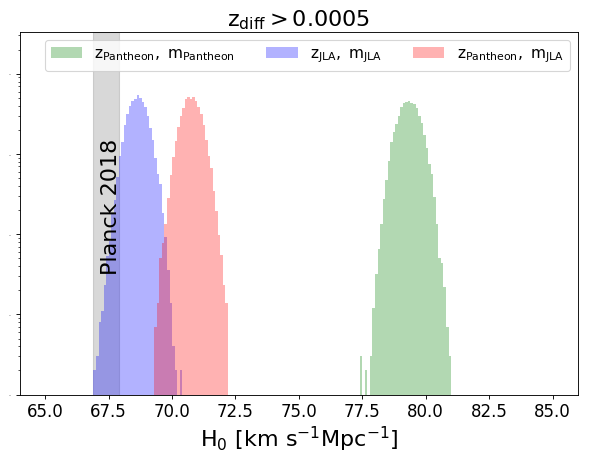

In [121]:
b = np.linspace(65, 85, 201)
k = plt.hist(resultz10m11sp0005.flatchain['h']*100., bins=b, color='green', alpha=0.3, label = r'$\rm{ z_{Pantheon},\ m_{Pantheon} }$')
plt.hist(resultz9m1sp0005.flatchain['h']*100., bins=k[1], color='blue', alpha=0.3, label = r'$\rm{ z_{JLA},\  m_{JLA} }$')
plt.hist(resultz10m1sp0005.flatchain['h']*100., bins=k[1], color='red', alpha=0.3, label = r'$\rm{ z_{Pantheon},\  m_{JLA} }$')
plt.fill_betweenx(y, x1, x2, color='grey', alpha=0.3)
plt.text(67.2, 1000, 'Planck 2018', rotation=90, fontsize=20)
#plt.hist(resultz10m11sp0005.flatchain['h']*100., bins=k[1], color='green', alpha=0.3, label = r'$\rm{ z_{Pantheon},\ M_{Pantheon} }$')
plt.xlabel(r'$ {\rm H_0 }\ [{\rm km\ s}^{-1} {\rm Mpc}^{-1}]$', fontsize=20)
plt.legend(loc='best', fontsize=14, ncol=3)
plt.title(r'$\rm{ z_{diff} > 0.0005 }$', fontsize=20)
plt.yscale('log')
plt.ylim(1, 33000)

In [67]:
shiftsel = np.absolute(jnzd)>0.0025
Z, COVd = GenerateDsetAndCov(shiftsel)
print(len(Z))

58


In [68]:
ZINDEX = 9
MAGINDEX = 1
STRETCHINDEX = 2
COLORINDEX = 3
minner = Minimizer(lmfitccVM, lmp)
resultz9m1spabs0025 = minner.emcee(steps = 1500, nwalkers=100, burn=1000)

In [69]:
ZINDEX = 10
MAGINDEX = 1
STRETCHINDEX = 2
COLORINDEX = 3
minner = Minimizer(lmfitccVM, lmp)
resultz10m1spabs0025 = minner.emcee(steps = 1500, nwalkers=100, burn=1000)

In [70]:
ZINDEX = 10
MAGINDEX = 11
STRETCHINDEX = 12
COLORINDEX = 13
minner = Minimizer(lmfitccVM, lmp)
resultz10m11spabs0025 = minner.emcee(steps = 1500, nwalkers=100, burn=1000)

(1, 33000)

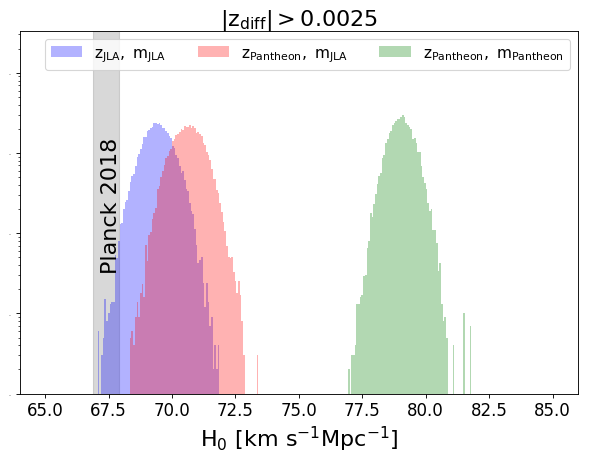

In [122]:
bn = np.linspace(65., 85., 301)

k = plt.hist(resultz9m1spabs0025.flatchain['h']*100., bins=bn, color='blue', alpha=0.3, label = r'$\rm{ z_{JLA},\  m_{JLA} }$')
plt.hist(resultz10m1spabs0025.flatchain['h']*100., bins=k[1], color='red', alpha=0.3, label = r'$\rm{ z_{Pantheon},\  m_{JLA} }$')
plt.hist(resultz10m11spabs0025.flatchain['h']*100., bins=k[1], color='green', alpha=0.3, label = r'$\rm{ z_{Pantheon},\ m_{Pantheon} }$')
plt.fill_betweenx(y, x1, x2, color='grey', alpha=0.3)
plt.text(67.2, 1000, 'Planck 2018', rotation=90, fontsize=20)
plt.xlabel(r'$ {\rm H_0 }\ [{\rm km\ s}^{-1} {\rm Mpc}^{-1}]$', fontsize=20)
plt.legend(loc='best', fontsize=14, ncol=3)
plt.title(r'$\rm{ |z_{diff}| > 0.0025 }$', fontsize=20)
plt.yscale('log')
plt.ylim(1, 33000)

In [86]:
print(np.median(resultz9m1spabs0025.flatchain['h']*100.))

69.43322250107076


In [88]:
print(np.median(resultz10m1spabs0025.flatchain['h']*100.))

70.63615954095107


In [94]:
shiftsel = np.absolute(jnzd)>0.0005
Z, COVd = GenerateDsetAndCov(shiftsel)
print(len(Z))

130


In [95]:
ZINDEX = 9
MAGINDEX = 1
STRETCHINDEX = 2
COLORINDEX = 3
minner = Minimizer(lmfitccVM, lmp)
resultz9m1spabs0005 = minner.emcee(steps = 1500, nwalkers=100, burn=1000)

/lustre/hpc/icecube/mrameez/.local/lib/python3.5/site-packages/lmfit/minimizer.py:1356: RuntimeWarning: overflow encountered in exp
  result.chisqr = np.exp(_neg2_log_likel)


In [96]:
ZINDEX = 10
MAGINDEX = 1
STRETCHINDEX = 2
COLORINDEX = 3
minner = Minimizer(lmfitccVM, lmp)
resultz10m1spabs0005 = minner.emcee(steps = 1500, nwalkers=100, burn=1000)

In [97]:
ZINDEX = 10
MAGINDEX = 11
STRETCHINDEX = 12
COLORINDEX = 13
minner = Minimizer(lmfitccVM, lmp)
resultz10m11spabs0005 = minner.emcee(steps = 1500, nwalkers=100, burn=1000)

(1, 33000)

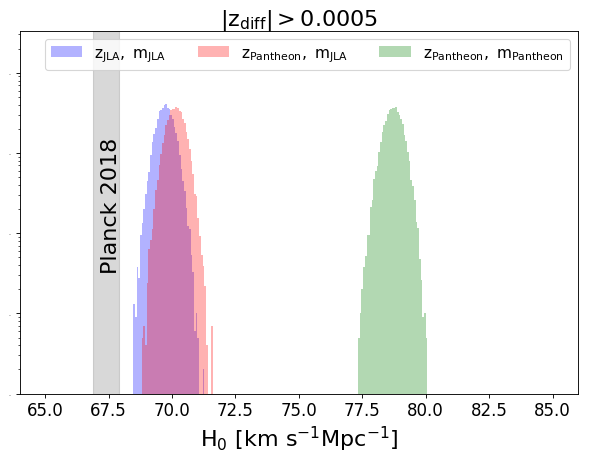

In [123]:
bn = np.linspace(65., 85., 301)

k = plt.hist(resultz9m1spabs0005.flatchain['h']*100., bins=bn, color='blue', alpha=0.3, label = r'$\rm{ z_{JLA},\  m_{JLA} }$')
plt.hist(resultz10m1spabs0005.flatchain['h']*100., bins=k[1], color='red', alpha=0.3, label = r'$\rm{ z_{Pantheon},\  m_{JLA} }$')
plt.hist(resultz10m11spabs0005.flatchain['h']*100., bins=k[1], color='green', alpha=0.3, label = r'$\rm{ z_{Pantheon},\ m_{Pantheon} }$')
plt.fill_betweenx(y, x1, x2, color='grey', alpha=0.3)
plt.text(67.2, 1000, 'Planck 2018', rotation=90, fontsize=20)
plt.xlabel(r'$ {\rm H_0 }\ [{\rm km\ s}^{-1} {\rm Mpc}^{-1}]$', fontsize=20)
plt.legend(loc='best', fontsize=14, ncol=3)
plt.title(r'$\rm{ |z_{diff}| > 0.0005 }$', fontsize=20)
plt.yscale('log')
plt.ylim(1, 33000)